In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

YEAR = 2021
filePath = '/Users/Firefly/Desktop/_iMac_Drive/Joseph/Coding/NFL/Jupyter/'

data = nfl.import_pbp_data([YEAR])

ref_data = pd.read_csv('https://raw.githubusercontent.com/Josephhero/2021_referee_assignments/main/ref_data_2021.csv', low_memory=False)

team_desc = nfl.import_team_desc()

# This turns off the 'SettingWithCopyWarning' that would otherwise be triggered 
# by something in the following code. 
# Since this is just getting the raw and cleaned data, we're going to just ignore it here.
pd.options.mode.chained_assignment = None

# These two lines set the scroll options so you can scroll vertically and horizontally.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


2021 done.
Downcasting floats.


In [2]:
# Set variables
maxWeek = ref_data.week.max()

# Copy data to new df and filter
df = data.copy()
df = df.loc[df.penalty==1]

# Filter the df down to the fields you'll need
df = df.filter(['game_id', 'home_team', 'away_team', 'week', 'penalty_team', 'penalty_type', 'penalty'])

# Copy ref_data and filter
ref = ref_data.copy()
ref = ref.filter(['game_id', 'referee'])

# Merge df and ref so you have the referee name now with the rest of the data you need
pen = pd.merge(df, ref, how='inner', left_on='game_id', right_on='game_id')

# Copy pen and group it so you have the count of penalties for each team for every game
pen_by_game = pen.copy()
pen_by_game = pen_by_game.groupby(['game_id', 'penalty_team', 'referee'])[['penalty']].count().reset_index()

# Copy pen_by_game and group it so you have the mean penalties per game for each team
avg_team_pen = pen_by_game.copy()
avg_team_pen = avg_team_pen.groupby('penalty_team')['penalty'].mean().reset_index()
avg_team_pen = avg_team_pen.sort_values(by='penalty')
avg_team_pen = avg_team_pen.rename(columns={'penalty':'avg_penalties_game'})
avg_team_pen


,penalty_team,avg_penalties_game
23,NYG,3.857143
31,WAS,4.000000
9,DEN,4.000000
6,CIN,4.142857
11,GB,4.142857
16,LA,4.285714
13,IND,4.428571
29,TB,4.500000
21,NE,5.000000
1,ATL,5.250000


In [3]:
# Merge pen_by_game and avg_team_pen so you can create the field 'penalties_over_expected'
team_pen = pd.merge(pen_by_game, avg_team_pen, how='inner', left_on='penalty_team', right_on='penalty_team')
team_pen = team_pen.sort_values(by='game_id')
team_pen['penalties_over_expected'] = team_pen.penalty - team_pen.avg_penalties_game

# Copy team_pen and group it so you have the sum of the total 'penalties_over_expected' for each referee
ref_pen = team_pen.copy()
ref_pen = ref_pen.groupby(['referee', 'game_id'])[['penalty', 'penalties_over_expected']].sum().reset_index()
ref_pen = ref_pen.sort_values(by='game_id')

# Copy ref_pen and group it so you get the mean of 'penalties_over_expected' for each referee
avg_ref_pen = ref_pen.groupby('referee')[['penalty', 'penalties_over_expected']].mean().reset_index()
avg_ref_pen = avg_ref_pen.sort_values(by='penalties_over_expected')
avg_ref_pen = avg_ref_pen.rename(columns={'penalty':'avg_ref_penalties_game', 'penalties_over_expected':'ref_penalties_over_expected'})
avg_ref_pen = avg_ref_pen.reset_index(drop=True)
avg_ref_pen


,referee,avg_ref_penalties_game,ref_penalties_over_expected
0,John Hussey,9.166667,-2.048611
1,Bill Vinovich,9.571429,-1.589286
2,Ron Torbert,10.000000,-1.113095
3,Jerome Boger,11.000000,-0.964286
4,Tony Corrente,9.857143,-0.859694
5,Craig Wrolstad,10.125000,-0.825893
6,Brad Rogers,10.857143,-0.627551
7,Shawn Smith,10.857143,-0.449830
8,Clete Blakeman,10.857143,-0.397959
9,Clay Martin,11.571429,-0.012755


In [4]:
# Filter ref_data down to just the current week
week_df = ref_data.loc[ref_data.week==maxWeek]

# Merge week_df and avg_team_pen so you have the referee for the 'away' team
away_team = pd.merge(week_df, avg_team_pen, how='inner', left_on='away', right_on='penalty_team')
away_team = away_team.rename(columns={'avg_penalties_game':'away_avg_penalties_game'})

# Merge away_team and avg_team_pen so you have the referee for the home team as well as the away team
home_team = pd.merge(away_team, avg_team_pen, how='inner', left_on='home', right_on='penalty_team')
home_team = home_team.rename(columns={'avg_penalties_game':'home_avg_penalties_game'})

In [5]:
# Merge home_team and avg_ref_pen so you get the ref penalties_over_expected for each game
week_ref = pd.merge(home_team, avg_ref_pen, how='inner', left_on='referee', right_on='referee')

# Create a field for 'avg_team_penalties' with the sum of away and home team averages
# then create 'expected_penalties' by adding 'ref_penalties_over_expected' to it. 
week_ref['avg_team_penalties'] = week_ref.away_avg_penalties_game + week_ref.home_avg_penalties_game
week_ref['expected_penalties'] = week_ref.avg_team_penalties + week_ref.ref_penalties_over_expected
week_ref['game'] = week_ref.away + '@' + week_ref.home
week_ref = week_ref.sort_values(by='expected_penalties', ascending=False)
week_ref = week_ref.reset_index()
week_ref

,index,game_id,year,week,away,home,referee,penalty_team_x,away_avg_penalties_game,penalty_team_y,home_avg_penalties_game,avg_ref_penalties_game,ref_penalties_over_expected,avg_team_penalties,expected_penalties,game
0,8,2021_18_PIT_BAL,2021,18,PIT,BAL,Shawn Hochuli,PIT,6.125000,BAL,6.625000,13.571429,2.420918,12.750000,15.170918,PIT@BAL
1,10,2021_18_TEN_HOU,2021,18,TEN,HOU,Land Clark,TEN,5.571429,HOU,6.428571,13.285714,2.109694,12.000000,14.109694,TEN@HOU
2,9,2021_18_LAC_LV,2021,18,LAC,LV,Clete Blakeman,LAC,6.750000,LV,7.625000,10.857143,-0.397959,14.375000,13.977041,LAC@LV
3,15,2021_18_CHI_MIN,2021,18,CHI,MIN,Brad Allen,CHI,6.571429,MIN,6.000000,11.714286,0.460884,12.571429,13.032313,CHI@MIN
4,5,2021_18_SEA_ARI,2021,18,SEA,ARI,Shawn Smith,SEA,5.875000,ARI,6.714286,10.857143,-0.449830,12.589286,12.139456,SEA@ARI
5,1,2021_18_DAL_PHI,2021,18,DAL,PHI,Ron Torbert,DAL,7.375000,PHI,5.857143,10.000000,-1.113095,13.232143,12.119048,DAL@PHI
6,2,2021_18_NE_MIA,2021,18,NE,MIA,Alex Kemp,NE,5.000000,MIA,6.166667,11.714286,0.611395,11.166667,11.778061,NE@MIA
7,13,2021_18_GB_DET,2021,18,GB,DET,Scott Novak,GB,4.142857,DET,6.250000,12.857143,0.811224,10.392857,11.204082,GB@DET
8,7,2021_18_NO_ATL,2021,18,NO,ATL,Craig Wrolstad,NO,5.428571,ATL,5.250000,10.125000,-0.825893,10.678571,9.852679,NO@ATL
9,6,2021_18_IND_JAX,2021,18,IND,JAX,Clay Martin,IND,4.428571,JAX,5.375000,11.571429,-0.012755,9.803571,9.790816,IND@JAX


In [6]:
# Filter team_desc to just the necessary columns
team_df = team_desc.filter(['team_abbr', 'team_color', 'team_logo_espn'])

# Merge week_ref with team_df to get the colors and logos for the away team
week_ref_away = pd.merge(week_ref, team_df, how = 'inner', left_on = 'away', right_on = 'team_abbr')
# Merge week_ref_away with team_df to get the colors and logos for the home team
week_ref_away_home = pd.merge(week_ref_away, team_df, how = 'inner', left_on = 'home', right_on = 'team_abbr')
week_ref_away_home

,index,game_id,year,week,away,home,referee,penalty_team_x,away_avg_penalties_game,penalty_team_y,home_avg_penalties_game,avg_ref_penalties_game,ref_penalties_over_expected,avg_team_penalties,expected_penalties,game,team_abbr_x,team_color_x,team_logo_espn_x,team_abbr_y,team_color_y,team_logo_espn_y
0,8,2021_18_PIT_BAL,2021,18,PIT,BAL,Shawn Hochuli,PIT,6.125000,BAL,6.625000,13.571429,2.420918,12.750000,15.170918,PIT@BAL,PIT,#000000,https://a.espncdn.com/i/teamlogos/nfl/500/pit.png,BAL,#241773,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
1,10,2021_18_TEN_HOU,2021,18,TEN,HOU,Land Clark,TEN,5.571429,HOU,6.428571,13.285714,2.109694,12.000000,14.109694,TEN@HOU,TEN,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/ten.png,HOU,#03202F,https://a.espncdn.com/i/teamlogos/nfl/500/hou.png
2,9,2021_18_LAC_LV,2021,18,LAC,LV,Clete Blakeman,LAC,6.750000,LV,7.625000,10.857143,-0.397959,14.375000,13.977041,LAC@LV,LAC,#007BC7,https://a.espncdn.com/i/teamlogos/nfl/500/lac.png,LV,#000000,https://a.espncdn.com/i/teamlogos/nfl/500/lv.png
3,15,2021_18_CHI_MIN,2021,18,CHI,MIN,Brad Allen,CHI,6.571429,MIN,6.000000,11.714286,0.460884,12.571429,13.032313,CHI@MIN,CHI,#0B162A,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png,MIN,#4F2683,https://a.espncdn.com/i/teamlogos/nfl/500/min.png
4,5,2021_18_SEA_ARI,2021,18,SEA,ARI,Shawn Smith,SEA,5.875000,ARI,6.714286,10.857143,-0.449830,12.589286,12.139456,SEA@ARI,SEA,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/sea.png,ARI,#97233F,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
5,1,2021_18_DAL_PHI,2021,18,DAL,PHI,Ron Torbert,DAL,7.375000,PHI,5.857143,10.000000,-1.113095,13.232143,12.119048,DAL@PHI,DAL,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png,PHI,#004C54,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png
6,2,2021_18_NE_MIA,2021,18,NE,MIA,Alex Kemp,NE,5.000000,MIA,6.166667,11.714286,0.611395,11.166667,11.778061,NE@MIA,NE,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/ne.png,MIA,#008E97,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
7,13,2021_18_GB_DET,2021,18,GB,DET,Scott Novak,GB,4.142857,DET,6.250000,12.857143,0.811224,10.392857,11.204082,GB@DET,GB,#203731,https://a.espncdn.com/i/teamlogos/nfl/500/gb.png,DET,#0076B6,https://a.espncdn.com/i/teamlogos/nfl/500/det.png
8,7,2021_18_NO_ATL,2021,18,NO,ATL,Craig Wrolstad,NO,5.428571,ATL,5.250000,10.125000,-0.825893,10.678571,9.852679,NO@ATL,NO,#D3BC8D,https://a.espncdn.com/i/teamlogos/nfl/500/no.png,ATL,#A71930,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
9,6,2021_18_IND_JAX,2021,18,IND,JAX,Clay Martin,IND,4.428571,JAX,5.375000,11.571429,-0.012755,9.803571,9.790816,IND@JAX,IND,#002C5F,https://a.espncdn.com/i/teamlogos/nfl/500/ind.png,JAX,#006778,https://a.espncdn.com/i/teamlogos/nfl/500/jax.png


In [7]:
week_ref_away_home = week_ref_away_home.rename(columns=
                                               {'team_color_x':'team_color_away', 
                                                'team_color_y':'team_color_home', 
                                                'team_logo_espn_x':'team_logo_espn_away', 
                                                'team_logo_espn_y':'team_logo_espn_home'})
week_ref_away_home



,index,game_id,year,week,away,home,referee,penalty_team_x,away_avg_penalties_game,penalty_team_y,home_avg_penalties_game,avg_ref_penalties_game,ref_penalties_over_expected,avg_team_penalties,expected_penalties,game,team_abbr_x,team_color_away,team_logo_espn_away,team_abbr_y,team_color_home,team_logo_espn_home
0,8,2021_18_PIT_BAL,2021,18,PIT,BAL,Shawn Hochuli,PIT,6.125000,BAL,6.625000,13.571429,2.420918,12.750000,15.170918,PIT@BAL,PIT,#000000,https://a.espncdn.com/i/teamlogos/nfl/500/pit.png,BAL,#241773,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
1,10,2021_18_TEN_HOU,2021,18,TEN,HOU,Land Clark,TEN,5.571429,HOU,6.428571,13.285714,2.109694,12.000000,14.109694,TEN@HOU,TEN,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/ten.png,HOU,#03202F,https://a.espncdn.com/i/teamlogos/nfl/500/hou.png
2,9,2021_18_LAC_LV,2021,18,LAC,LV,Clete Blakeman,LAC,6.750000,LV,7.625000,10.857143,-0.397959,14.375000,13.977041,LAC@LV,LAC,#007BC7,https://a.espncdn.com/i/teamlogos/nfl/500/lac.png,LV,#000000,https://a.espncdn.com/i/teamlogos/nfl/500/lv.png
3,15,2021_18_CHI_MIN,2021,18,CHI,MIN,Brad Allen,CHI,6.571429,MIN,6.000000,11.714286,0.460884,12.571429,13.032313,CHI@MIN,CHI,#0B162A,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png,MIN,#4F2683,https://a.espncdn.com/i/teamlogos/nfl/500/min.png
4,5,2021_18_SEA_ARI,2021,18,SEA,ARI,Shawn Smith,SEA,5.875000,ARI,6.714286,10.857143,-0.449830,12.589286,12.139456,SEA@ARI,SEA,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/sea.png,ARI,#97233F,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
5,1,2021_18_DAL_PHI,2021,18,DAL,PHI,Ron Torbert,DAL,7.375000,PHI,5.857143,10.000000,-1.113095,13.232143,12.119048,DAL@PHI,DAL,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png,PHI,#004C54,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png
6,2,2021_18_NE_MIA,2021,18,NE,MIA,Alex Kemp,NE,5.000000,MIA,6.166667,11.714286,0.611395,11.166667,11.778061,NE@MIA,NE,#002244,https://a.espncdn.com/i/teamlogos/nfl/500/ne.png,MIA,#008E97,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
7,13,2021_18_GB_DET,2021,18,GB,DET,Scott Novak,GB,4.142857,DET,6.250000,12.857143,0.811224,10.392857,11.204082,GB@DET,GB,#203731,https://a.espncdn.com/i/teamlogos/nfl/500/gb.png,DET,#0076B6,https://a.espncdn.com/i/teamlogos/nfl/500/det.png
8,7,2021_18_NO_ATL,2021,18,NO,ATL,Craig Wrolstad,NO,5.428571,ATL,5.250000,10.125000,-0.825893,10.678571,9.852679,NO@ATL,NO,#D3BC8D,https://a.espncdn.com/i/teamlogos/nfl/500/no.png,ATL,#A71930,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
9,6,2021_18_IND_JAX,2021,18,IND,JAX,Clay Martin,IND,4.428571,JAX,5.375000,11.571429,-0.012755,9.803571,9.790816,IND@JAX,IND,#002C5F,https://a.espncdn.com/i/teamlogos/nfl/500/ind.png,JAX,#006778,https://a.espncdn.com/i/teamlogos/nfl/500/jax.png


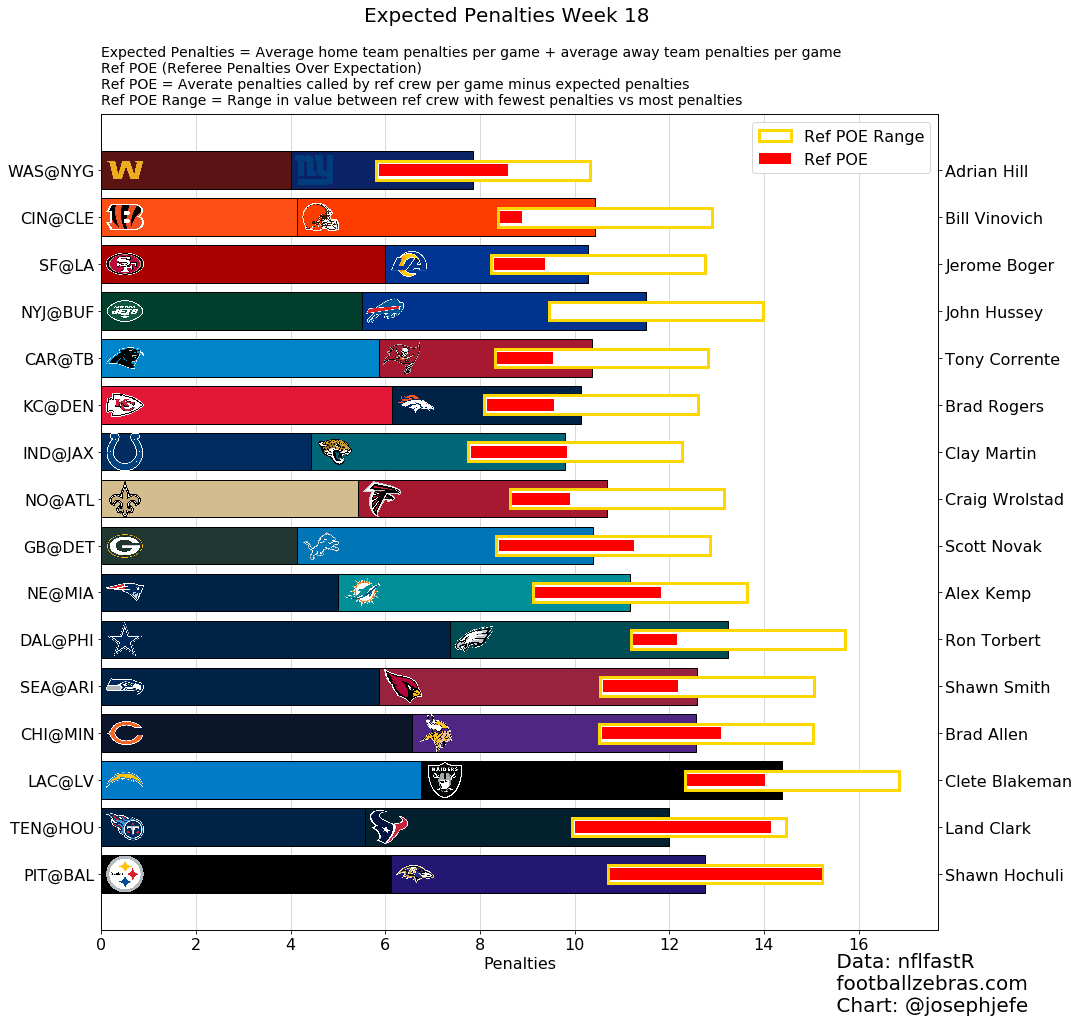

In [9]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Assign values
labels = week_ref_away_home.game
home = week_ref_away_home.home_avg_penalties_game
away = week_ref_away_home.away_avg_penalties_game
avg_team_penalties = week_ref_away_home.avg_team_penalties
ref_poe = week_ref_away_home.ref_penalties_over_expected
home_colors = week_ref_away_home.team_color_home
away_colors = week_ref_away_home.team_color_away
home_logos = week_ref_away_home.team_logo_espn_home
away_logos = week_ref_away_home.team_logo_espn_away
refs = week_ref_away_home.referee
game_count = week_ref_away_home.game_id.count()

# Create a figure
fig, ax, = plt.subplots(figsize=(15, 15))

# Create stacked bar chart
ax.barh(labels, away, color=away_colors, edgecolor='black')
ax.barh(labels, home, left=away, color=home_colors, edgecolor='black')

# Set up ref_poe data
poe_min = avg_ref_pen.ref_penalties_over_expected.min()
poe_max = avg_ref_pen.ref_penalties_over_expected.max()
poe_diff = (poe_max - poe_min) + 0.05
poe_mid = poe_diff*0.5

# Set up fill bars
ax.barh(labels, poe_diff, left=avg_team_penalties+poe_min, height=0.4, color='white', edgecolor='gold', linewidth=3, label='Ref POE Range')

# Now fill the fill bars
ax.barh(labels, (ref_poe - poe_min), left=(avg_team_penalties+poe_min) + 0.05, height=0.25, color='red', linewidth=3, label='Ref POE')

# Add ref names on right y axis
ax2 = ax.twinx()
ax2.barh(labels, away, color=away_colors, edgecolor='black', alpha=0)
ax2.set_yticklabels(refs, fontsize=16)

# Add grid
ax.grid(zorder=0,alpha=.6,axis='x')
ax.set_axisbelow(True)

#ax.set_yticklabels(labels, fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel('Penalties', fontsize=16)

#Add logos to chart
#X data is an array from 0-game_count(game_count is number of games played during the current week)
# This AnnotationBbox code is from @DeryckG's excellent tutorial on using nflfastR found here:
# https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e
# I don't actually understand how this part works. It's black magic. But if you need the logos to append in a 
# vertical bar graph instead of horizontal like this one, just swap the "path in zip(x,y)" to "path in zip (y,x)"

for x0, y0, path in zip(away - (away - 0.5), np.arange(0,game_count), away_logos):
    ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.08), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
for x0, y0, path in zip(away + 0.5, np.arange(0,game_count), home_logos):
    ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.08), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
# Add legend
ax.legend(fontsize=16)

# Set Title
title = 'Expected Penalties Week ' + str(maxWeek)
text1 = 'Expected Penalties = Average home team penalties per game + average away team penalties per game'
text2 = 'Ref POE (Referee Penalties Over Expectation)'
text3 = 'Ref POE = Averate penalties called by ref crew per game minus expected penalties'
text4 = 'Ref POE Range = Range in value between ref crew with fewest penalties vs most penalties'
plt.suptitle(str(title), fontsize=20)
ax.set_title(str(text1) + '\n' + str(text2) + '\n' + str(text3) + '\n' + str(text4), fontsize=14, loc='left', pad=10)
plt.figtext(.80,.05,' Data: nflfastR \n footballzebras.com \n Chart: @josephjefe' ,fontsize=20)

#plt.subplots_adjust(top=0.9)

#Save the figure as a png
plt.savefig(filePath + 'Figures/' + str(title) + '.png', bbox_inches='tight', dpi=400)
plt.show()


In [10]:
final = week_ref.filter(['home', 'away', 'referee', 'avg_team_penalties', 'ref_penalties_over_expected', 'expected_penalties'])
final = final.rename(columns={'ref_penalties_over_expected':'ref_poe'})
final = final.sort_values(by='expected_penalties')
final = final.round(1)
final


,home,away,referee,avg_team_penalties,ref_poe,expected_penalties
15,NYG,WAS,Adrian Hill,7.9,0.7,8.6
14,CLE,CIN,Bill Vinovich,10.4,-1.6,8.8
13,LA,SF,Jerome Boger,10.3,-1.0,9.3
12,BUF,NYJ,John Hussey,11.5,-2.0,9.5
11,TB,CAR,Tony Corrente,10.4,-0.9,9.5
10,DEN,KC,Brad Rogers,10.1,-0.6,9.5
9,JAX,IND,Clay Martin,9.8,-0.0,9.8
8,ATL,NO,Craig Wrolstad,10.7,-0.8,9.9
7,DET,GB,Scott Novak,10.4,0.8,11.2
6,MIA,NE,Alex Kemp,11.2,0.6,11.8


In [11]:
# Export Weekly Snaps Table as .png

import dataframe_image as dfi 

# Set a title (caption) for the table, and style it however you want.
title_text =  'Averate Team Penalties Weeks 1-' + str(maxWeek)

# Once the df is styled, you CANNOT style it again. It must be done all at once,
# which is why this is all wrapped in a parentheses.
df_png = (
    avg_team_pen.style
              .format(formatter={'avg_penalties_game':'{:.1f}', 'ref_penalties_over_expected':'{:.1f}', 'expected_penalties':'{:.1f}'})
              .hide_index()
              .set_caption('-<br>' + str(title_text))
              .set_table_styles([
                  {'selector':'caption'
                  , 'props':[
                      ('color', 'black')
                      , ('font-size', '16px')
                      , ('font-weight', 'bold')
                      , ('text-align', 'center')
                      , ('padding-top', '20px')
                  ]
                  },
                  {'selector':''
                  , 'props':[
                      ('border', '2px solid darkblue')
                      , ('padding-bottom', '20px')]
                  }
              ])
)

# Export the df as a .png image
dfi.export(df_png, filePath + 'Figures/' + str(title_text) + '.png')
df_png

penalty_team,avg_penalties_game
NYG,3.9
WAS,4.0
DEN,4.0
CIN,4.1
GB,4.1
LA,4.3
IND,4.4
TB,4.5
NE,5.0
ATL,5.2


In [12]:
# Export Weekly Snaps Table as .png

import dataframe_image as dfi 

# Set a title (caption) for the table, and style it however you want.
title_text =  'Referee Penalties Weeks 1-' + str(maxWeek)

# Once the df is styled, you CANNOT style it again. It must be done all at once,
# which is why this is all wrapped in a parentheses.
df_png = (
    avg_ref_pen.style
              .format(formatter={'avg_ref_penalties_game':'{:.1f}', 'ref_penalties_over_expected':'{:.1f}', 'expected_penalties':'{:.1f}'})
              .hide_index()
              .set_caption('-<br><span class="my-cls">' + str(title_text) + '</span><br> avg_ref_penalties_game = avg penalties the refs crew calls per game<br>ref_penalties_over_expected = avg penalties of home and away teams minus avg_ref_penalties_game')
              .set_table_styles([
                  {'selector':'.my-cls'
                  , 'props':[
                      ('color', 'black')
                      , ('font-size', '16px')
                      , ('font-weight', 'bold')
                      , ('text-align', 'center')
                      , ('padding-top', '20px')
                  ]
                  },
                  {'selector':'caption'
                  , 'props':[
                      ('color', 'black')
                      , ('font-size', '12px')
                      #, ('font-weight', 'bold')
                      , ('text-align', 'center')
                      , ('padding-top', '20px')
                  ]
                  },
                  {'selector':''
                  , 'props':[
                      ('border', '2px solid darkblue')
                      , ('padding-bottom', '20px')]
                  }
              ])
)

# Export the df as a .png image
dfi.export(df_png, filePath + 'Figures/' + str(title_text) + '.png')
df_png

referee,avg_ref_penalties_game,ref_penalties_over_expected
John Hussey,9.2,-2.0
Bill Vinovich,9.6,-1.6
Ron Torbert,10.0,-1.1
Jerome Boger,11.0,-1.0
Tony Corrente,9.9,-0.9
Craig Wrolstad,10.1,-0.8
Brad Rogers,10.9,-0.6
Shawn Smith,10.9,-0.4
Clete Blakeman,10.9,-0.4
Clay Martin,11.6,-0.0


In [13]:
# Export Weekly Snaps Table as .png

import dataframe_image as dfi 

# Set a title (caption) for the table, and style it however you want.
title_text =  'Expected Penalties Week ' + str(maxWeek)

# Once the df is styled, you CANNOT style it again. It must be done all at once,
# which is why this is all wrapped in a parentheses.
df_png = (
    final.style
              .format(formatter={'avg_team_penalties':'{:.1f}', 'ref_poe':'{:.1f}', 'expected_penalties':'{:.1f}'})
              .hide_index()
              .set_caption('-<br><span class="my-cls">' + str(title_text) + '</span><br>ref_poe = Referee Penalties Over Expected<br>expected_penalties = avg_team_penalties plus ref_poe')
              .set_table_styles([
                  {'selector':'.my-cls'
                  , 'props':[
                      ('color', 'black')
                      , ('font-size', '16px')
                      , ('font-weight', 'bold')
                      , ('text-align', 'center')
                      , ('padding-top', '20px')
                  ]
                  },
                  {'selector':'caption'
                  , 'props':[
                      ('color', 'black')
                      , ('font-size', '12px')
                      #, ('font-weight', 'bold')
                      , ('text-align', 'center')
                      , ('padding-top', '20px')
                  ]
                  },
                   {'selector':''
                  , 'props':[
                      ('border', '2px solid darkblue')
                      , ('padding-bottom', '20px')]
                  }
              ])
)

# Export the df as a .png image
dfi.export(df_png, filePath + 'Figures/' + str(title_text) + '.png')
df_png

home,away,referee,avg_team_penalties,ref_poe,expected_penalties
NYG,WAS,Adrian Hill,7.9,0.7,8.6
CLE,CIN,Bill Vinovich,10.4,-1.6,8.8
LA,SF,Jerome Boger,10.3,-1.0,9.3
BUF,NYJ,John Hussey,11.5,-2.0,9.5
TB,CAR,Tony Corrente,10.4,-0.9,9.5
DEN,KC,Brad Rogers,10.1,-0.6,9.5
JAX,IND,Clay Martin,9.8,-0.0,9.8
ATL,NO,Craig Wrolstad,10.7,-0.8,9.9
DET,GB,Scott Novak,10.4,0.8,11.2
MIA,NE,Alex Kemp,11.2,0.6,11.8
